## Environment set up and import Libraries

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


In [21]:
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [22]:
import os, keras, numpy
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *

## **Discriminator** Model

In [23]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):

  # input level
  in_label = Input(shape=(1,), name = "input_label")
  li = Embedding(n_classes, 50)(in_label)
  li = Dense(in_shape[0] * in_shape[1])(li)
  li = Reshape((in_shape[0], in_shape[1], 1))(li)

  # input image
  in_image = Input(shape=in_shape, name = "input_image")

  # concate 1
  merge = Concatenate()([in_image, li])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Embedding(n_classes, 50)(in_label)
  se1 = Dense(14*14, activation='relu')(se1)
  se1 = Reshape((14, 14, 1))(se1)

  merge1 = Concatenate()([fe, se1])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)
  fe = Flatten()(fe)
  fe = Dropout(0.2)(fe)
  
  # final layer
  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([in_image, in_label], out_layer)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
  return model
a = define_discriminator()
a.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 50)        500         ['input_label[0][0]']            
                                                                                                  
 dense_12 (Dense)               (None, 1, 784)       39984       ['embedding_6[0][0]']            
                                                                                                  
 input_image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                            

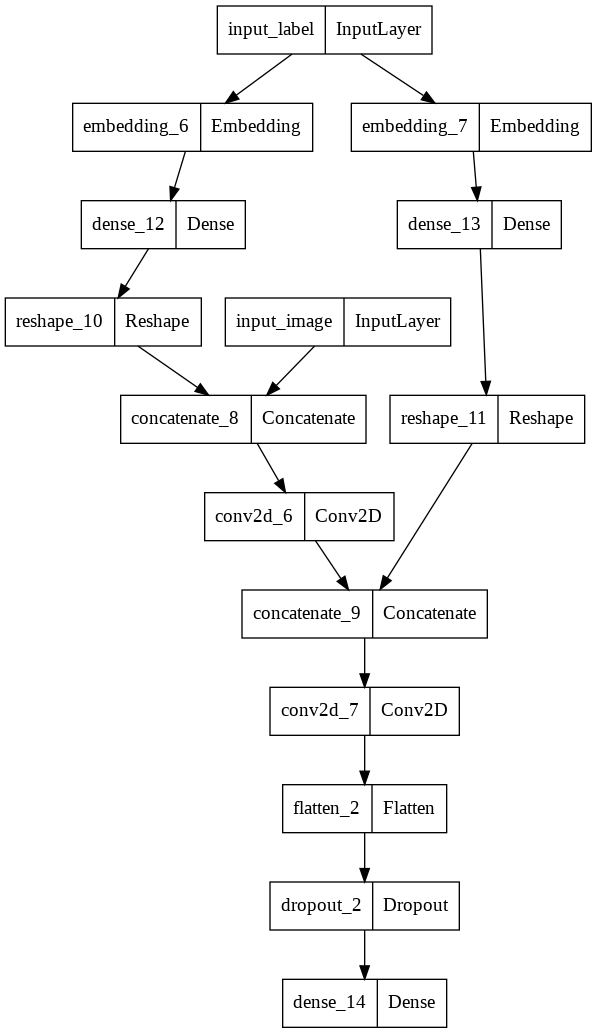

In [24]:
# plot the discriminator model
tf.keras.utils.plot_model(a)

## **Generator** Model

In [25]:
def define_generator(latent_dim = 100, n_classes=10):

  # label input
  in_label = Input(shape=(1,), name='in_label')
  li_embedd = Embedding(n_classes, 50)(in_label)
  li = Dense(7 * 7, activation='relu')(li_embedd)
  li = Reshape((7, 7, 1))(li)

  # latent input
  in_latent = Input(shape=(latent_dim,), name='in_latent')

  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes, activation = 'relu')(in_latent)
  gen = Reshape((7, 7, 128))(gen)

  # concate 1
  merge = Concatenate()([gen, li])

  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Dense(14*14, activation='relu')(li_embedd)
  se1 = Reshape((14, 14, 1))(se1)
  merge1 = Concatenate()([gen, se1])
  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)

  # final layer
  out_layer = Conv2D(1, (3,3), activation='tanh', padding='same')(gen)

  model = Model([in_latent, in_label], out_layer)
  return model
b = define_generator(100)
b.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 50)        500         ['in_label[0][0]']               
                                                                                                  
 dense_16 (Dense)               (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                            

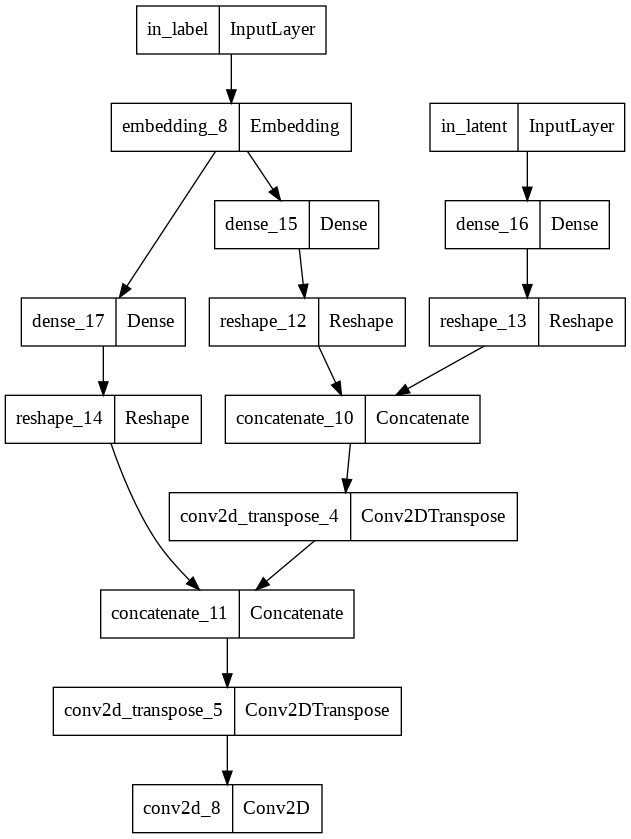

In [26]:
# plot the generator model
tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [27]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  gen_noise, gen_label = g_model.input
  gen_output = g_model.output

  gan_output = d_model([gen_output, gen_label])

  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 50)        500         ['in_label[0][0]']               
                                                                                                  
 dense_16 (Dense)               (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                            

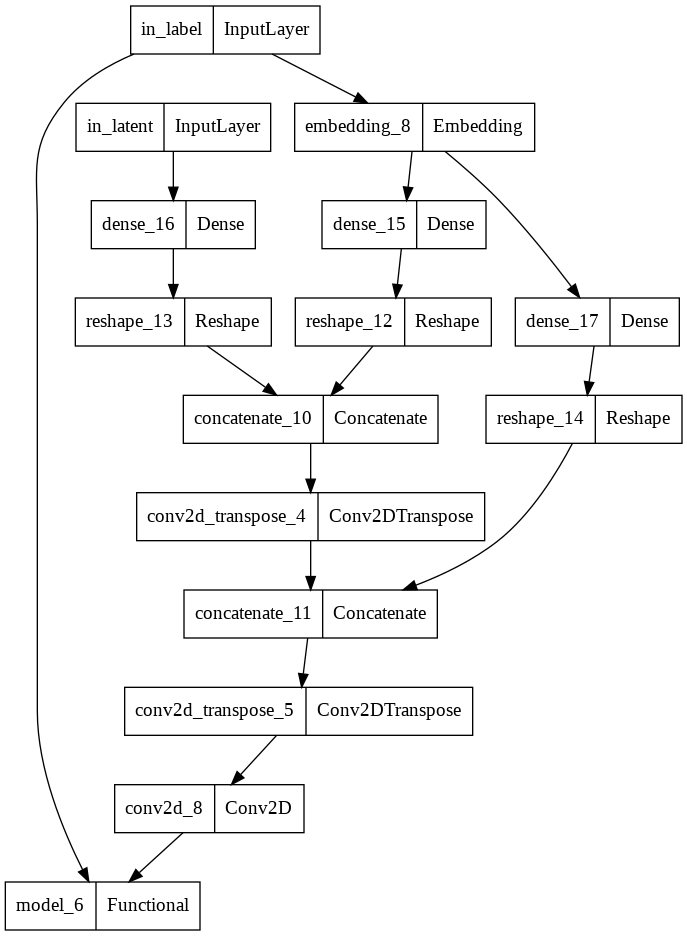

In [28]:
# plot GAN model
tf.keras.utils.plot_model(c)

## Load Mnist Dataset

In [29]:
def load_real_samples():
  # load dataset
  (trainX, trainy), (_, _) = mnist.load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]
k = load_real_samples()
print("image: ",k[0].shape," Lable: ",k[1].shape)
print("\nshape/size of the first 16 data: ",k[0][:16].shape)

image:  (60000, 28, 28, 1)  Lable:  (60000,)

shape/size of the first 16 data:  (16, 28, 28, 1)


## Plot data with label

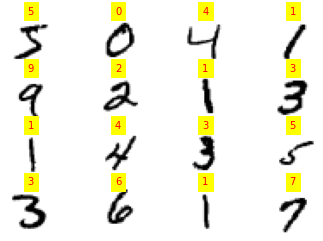

In [30]:
def save_plot(x_input,lebel,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.title(str(lebel[i]),fontsize=10,color="red",fontweight=10,pad='2.0',backgroundcolor='yellow')
        plt.imshow(x_input[i,:,:,0], cmap = 'gray_r')
        plt.axis('off')
    plt.show()
# plot data
save_plot(k[0][:16], k[1][:16])

## Generate real sample function

In [31]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y
d = generate_real_samples(k, 32)
print("Generate real data as a batch randomly: ",d[0][0].shape)

Generate real data as a batch randomly:  (32, 28, 28, 1)


## Generate latent point function

In [32]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]
p = generate_latent_points(100, 32)
print("Generate latent point(with label) as a batch: ",p[0].shape,p[1].shape)

Generate latent point(with label) as a batch:  (32, 100) (32,)


## Generate Fake samples of image with label

In [33]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y
with tf.device(device_name):
  kh = generate_fake_samples(b, 100, 32)
  print("shape of the generated images: ",kh[0][0].shape)

shape of the generated images:  (32, 28, 28, 1)


## Summarize the generator model

In [34]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points, labels = generate_latent_points(latent_dim= 100, n_samples= 16)
    X  = generator.predict([latent_points, labels])
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, labels, n=4)

## Train function

In [35]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=32):

  print("\nNo. of epoch: ",n_epochs)
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  print("\nbatch per epoch: ", bat_per_epo)
  print("\nfull batch: ", n_batch)
  half_batch = int(n_batch / 2)
  print("\nhalf batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += d_loss1

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += d_loss2

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += g_loss1

    d_loss_real_array.append(d_loss_r)
    d_loss_fake_array.append(d_loss_f)
    g_loss_array.append(g_loss)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %.2f, discriminator_loss_for_fake_data = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    summarize_the_model(g_model)
    # g_model.save("g_gan_model_"+str(i)+".h5")
    g_model.save("/content/drive/MyDrive/CGAN_mnist/MSELoss1/generator_model.h5")
    np.savez_compressed('/content/drive/MyDrive/CGAN_mnist/MSELoss1/loss_record.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function


READY TO GO !!!


No. of epoch:  60

batch per epoch:  1875

full batch:  32

half batch:  16 

************************************************** 


epoch -> [1/60], discriminator_loss_for_real_data = 373.92, discriminator_loss_for_fake_data = 372.31, generator_loss = 797.50



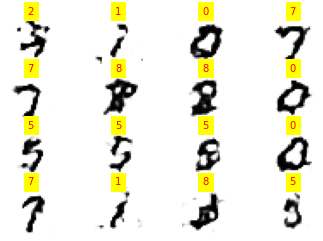



epoch -> [2/60], discriminator_loss_for_real_data = 343.91, discriminator_loss_for_fake_data = 320.23, generator_loss = 881.71



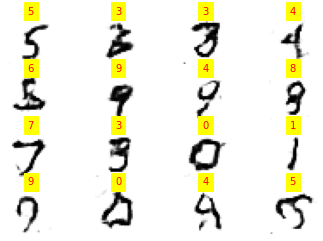



epoch -> [3/60], discriminator_loss_for_real_data = 393.19, discriminator_loss_for_fake_data = 363.85, generator_loss = 779.88



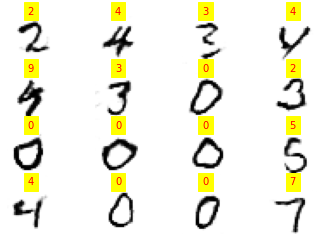



epoch -> [4/60], discriminator_loss_for_real_data = 420.51, discriminator_loss_for_fake_data = 397.23, generator_loss = 689.81



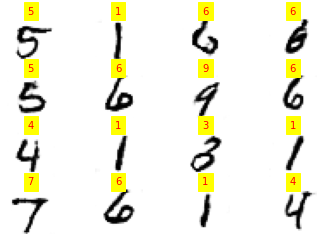



epoch -> [5/60], discriminator_loss_for_real_data = 424.08, discriminator_loss_for_fake_data = 403.62, generator_loss = 663.33



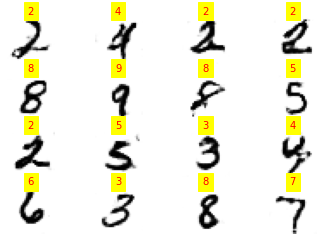



epoch -> [6/60], discriminator_loss_for_real_data = 427.73, discriminator_loss_for_fake_data = 409.60, generator_loss = 649.83



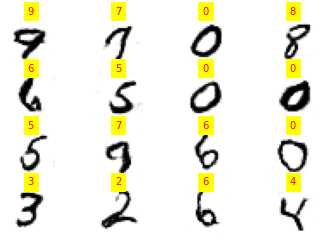



epoch -> [7/60], discriminator_loss_for_real_data = 424.83, discriminator_loss_for_fake_data = 405.63, generator_loss = 656.32



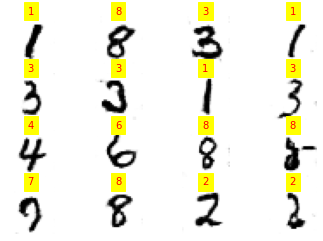



epoch -> [8/60], discriminator_loss_for_real_data = 424.27, discriminator_loss_for_fake_data = 404.07, generator_loss = 658.55



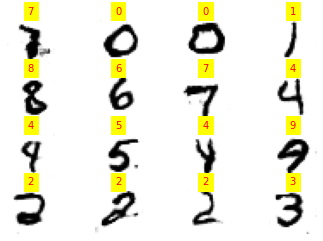



epoch -> [9/60], discriminator_loss_for_real_data = 420.89, discriminator_loss_for_fake_data = 399.34, generator_loss = 669.23



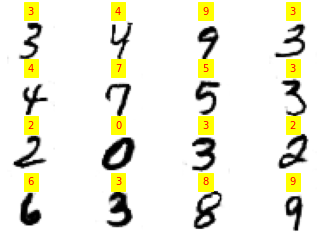



epoch -> [10/60], discriminator_loss_for_real_data = 415.62, discriminator_loss_for_fake_data = 392.38, generator_loss = 690.16



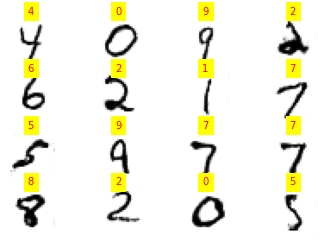



epoch -> [11/60], discriminator_loss_for_real_data = 415.14, discriminator_loss_for_fake_data = 388.23, generator_loss = 695.57



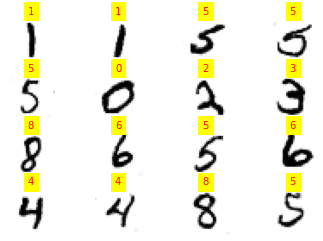



epoch -> [12/60], discriminator_loss_for_real_data = 409.76, discriminator_loss_for_fake_data = 382.02, generator_loss = 717.80



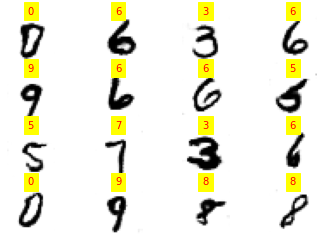



epoch -> [13/60], discriminator_loss_for_real_data = 407.33, discriminator_loss_for_fake_data = 373.45, generator_loss = 732.79



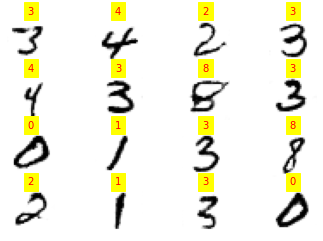



epoch -> [14/60], discriminator_loss_for_real_data = 404.08, discriminator_loss_for_fake_data = 369.74, generator_loss = 745.33



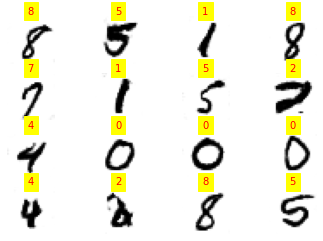



epoch -> [15/60], discriminator_loss_for_real_data = 400.61, discriminator_loss_for_fake_data = 366.33, generator_loss = 753.00



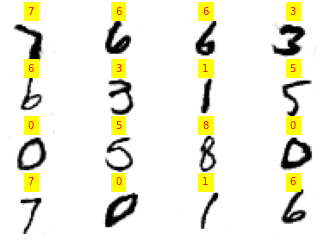



epoch -> [16/60], discriminator_loss_for_real_data = 399.16, discriminator_loss_for_fake_data = 360.98, generator_loss = 767.63



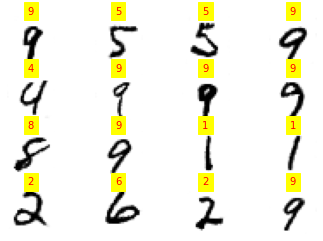



epoch -> [17/60], discriminator_loss_for_real_data = 395.68, discriminator_loss_for_fake_data = 357.12, generator_loss = 777.20



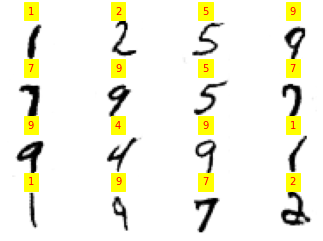



epoch -> [18/60], discriminator_loss_for_real_data = 391.38, discriminator_loss_for_fake_data = 354.32, generator_loss = 782.16



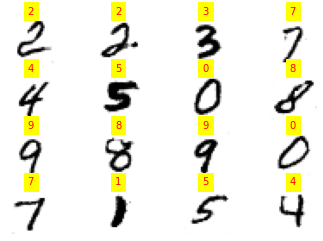



epoch -> [19/60], discriminator_loss_for_real_data = 390.48, discriminator_loss_for_fake_data = 349.83, generator_loss = 794.11



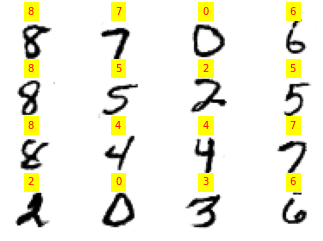



epoch -> [20/60], discriminator_loss_for_real_data = 389.51, discriminator_loss_for_fake_data = 346.52, generator_loss = 798.57



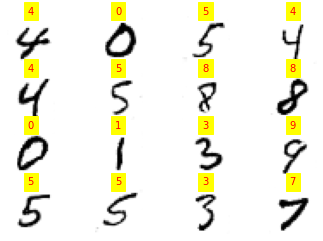



epoch -> [21/60], discriminator_loss_for_real_data = 388.72, discriminator_loss_for_fake_data = 344.11, generator_loss = 807.60



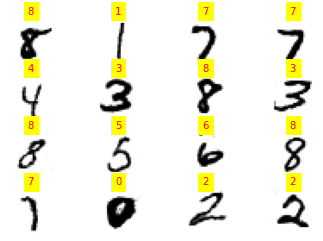



epoch -> [22/60], discriminator_loss_for_real_data = 388.28, discriminator_loss_for_fake_data = 341.77, generator_loss = 812.03



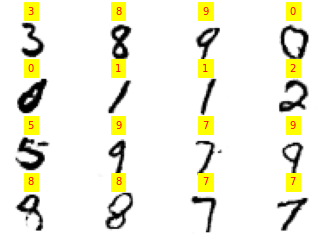



epoch -> [23/60], discriminator_loss_for_real_data = 386.08, discriminator_loss_for_fake_data = 340.68, generator_loss = 815.34



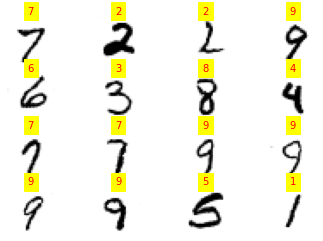



epoch -> [24/60], discriminator_loss_for_real_data = 382.65, discriminator_loss_for_fake_data = 338.18, generator_loss = 824.74



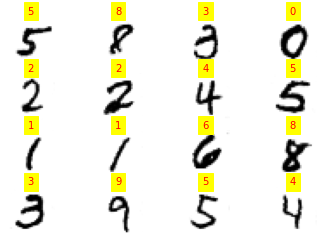



epoch -> [25/60], discriminator_loss_for_real_data = 381.16, discriminator_loss_for_fake_data = 333.76, generator_loss = 828.35



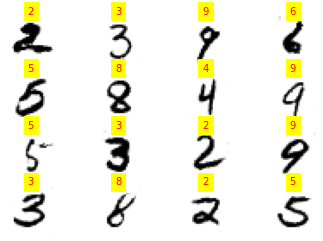



epoch -> [26/60], discriminator_loss_for_real_data = 379.70, discriminator_loss_for_fake_data = 333.27, generator_loss = 833.10



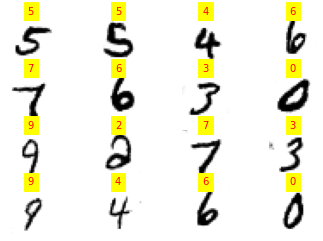



epoch -> [27/60], discriminator_loss_for_real_data = 380.62, discriminator_loss_for_fake_data = 330.86, generator_loss = 839.91



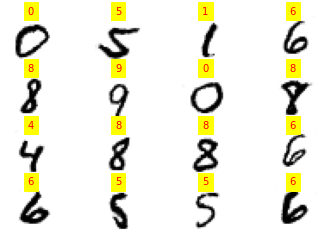



epoch -> [28/60], discriminator_loss_for_real_data = 377.87, discriminator_loss_for_fake_data = 330.23, generator_loss = 836.75



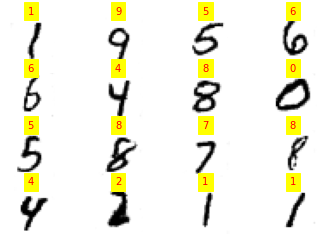



epoch -> [29/60], discriminator_loss_for_real_data = 378.47, discriminator_loss_for_fake_data = 326.78, generator_loss = 845.88



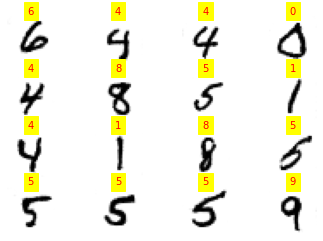



epoch -> [30/60], discriminator_loss_for_real_data = 379.80, discriminator_loss_for_fake_data = 326.89, generator_loss = 843.23



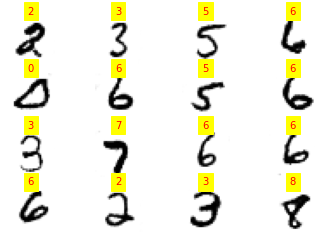



epoch -> [31/60], discriminator_loss_for_real_data = 377.74, discriminator_loss_for_fake_data = 323.60, generator_loss = 846.21



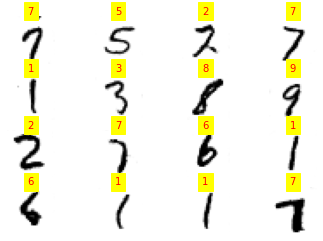



epoch -> [32/60], discriminator_loss_for_real_data = 377.61, discriminator_loss_for_fake_data = 327.34, generator_loss = 842.84



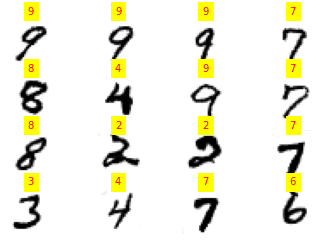



epoch -> [33/60], discriminator_loss_for_real_data = 374.33, discriminator_loss_for_fake_data = 321.28, generator_loss = 846.27



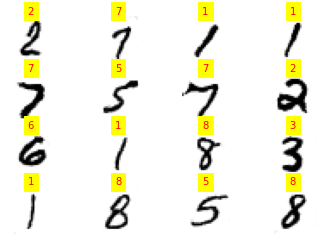



epoch -> [34/60], discriminator_loss_for_real_data = 374.39, discriminator_loss_for_fake_data = 321.07, generator_loss = 851.25



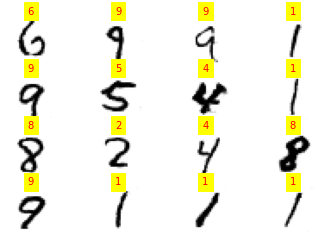



epoch -> [35/60], discriminator_loss_for_real_data = 370.21, discriminator_loss_for_fake_data = 320.37, generator_loss = 854.81



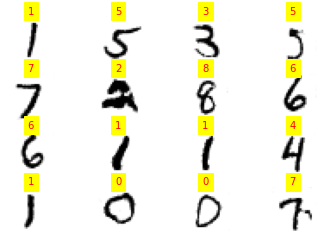



epoch -> [36/60], discriminator_loss_for_real_data = 372.31, discriminator_loss_for_fake_data = 319.72, generator_loss = 862.77



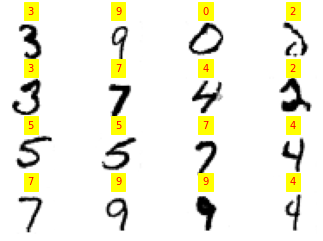



epoch -> [37/60], discriminator_loss_for_real_data = 368.75, discriminator_loss_for_fake_data = 313.80, generator_loss = 869.48



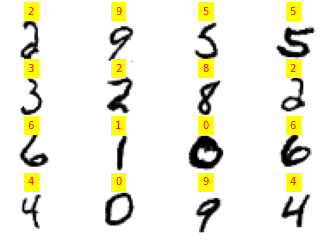



epoch -> [38/60], discriminator_loss_for_real_data = 367.94, discriminator_loss_for_fake_data = 316.75, generator_loss = 866.93



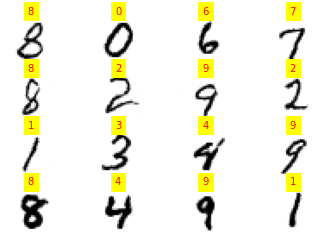



epoch -> [39/60], discriminator_loss_for_real_data = 367.60, discriminator_loss_for_fake_data = 315.40, generator_loss = 868.95



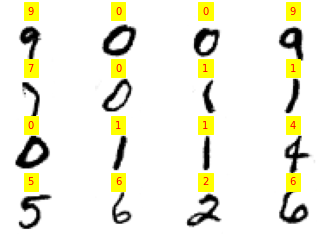



epoch -> [40/60], discriminator_loss_for_real_data = 366.38, discriminator_loss_for_fake_data = 313.34, generator_loss = 879.62



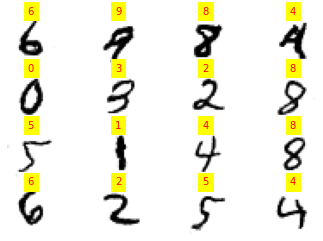



epoch -> [41/60], discriminator_loss_for_real_data = 365.82, discriminator_loss_for_fake_data = 308.73, generator_loss = 885.31



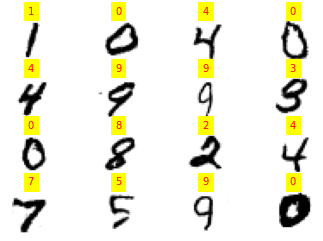



epoch -> [42/60], discriminator_loss_for_real_data = 364.29, discriminator_loss_for_fake_data = 309.46, generator_loss = 884.71



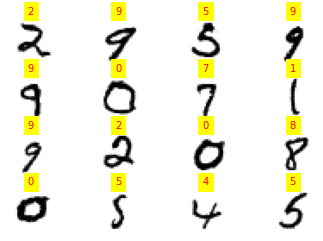



epoch -> [43/60], discriminator_loss_for_real_data = 363.54, discriminator_loss_for_fake_data = 308.01, generator_loss = 885.57



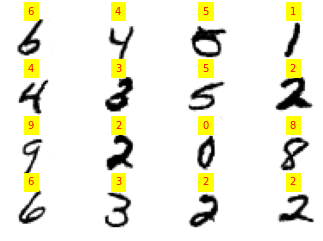



epoch -> [44/60], discriminator_loss_for_real_data = 360.67, discriminator_loss_for_fake_data = 305.13, generator_loss = 892.59



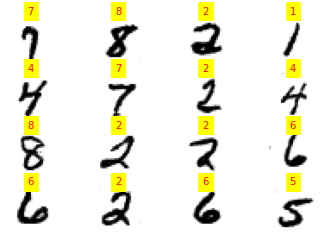



epoch -> [45/60], discriminator_loss_for_real_data = 359.42, discriminator_loss_for_fake_data = 304.08, generator_loss = 897.40



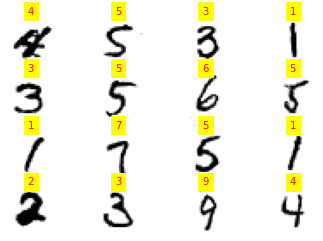



epoch -> [46/60], discriminator_loss_for_real_data = 358.58, discriminator_loss_for_fake_data = 305.40, generator_loss = 895.16



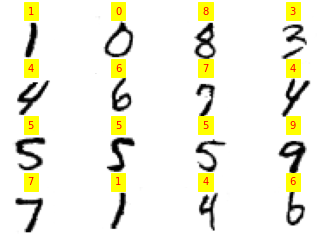



epoch -> [47/60], discriminator_loss_for_real_data = 358.45, discriminator_loss_for_fake_data = 302.03, generator_loss = 901.23



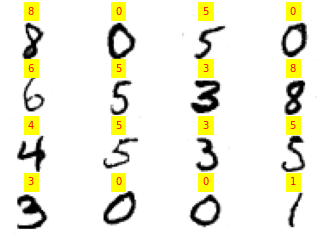



epoch -> [48/60], discriminator_loss_for_real_data = 352.82, discriminator_loss_for_fake_data = 297.61, generator_loss = 909.86



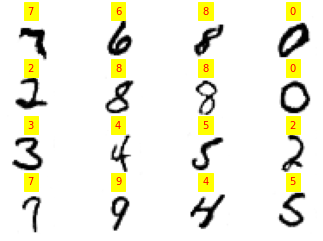



epoch -> [49/60], discriminator_loss_for_real_data = 352.35, discriminator_loss_for_fake_data = 300.09, generator_loss = 911.60



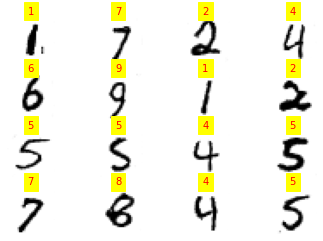



epoch -> [50/60], discriminator_loss_for_real_data = 348.81, discriminator_loss_for_fake_data = 293.32, generator_loss = 922.10



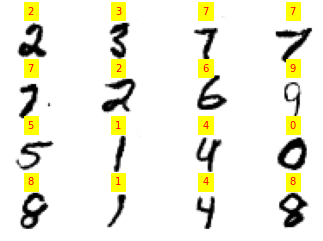



epoch -> [51/60], discriminator_loss_for_real_data = 347.15, discriminator_loss_for_fake_data = 290.11, generator_loss = 931.08



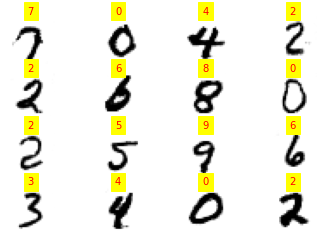



epoch -> [52/60], discriminator_loss_for_real_data = 342.93, discriminator_loss_for_fake_data = 285.84, generator_loss = 939.10



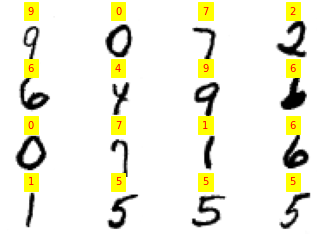



epoch -> [53/60], discriminator_loss_for_real_data = 342.19, discriminator_loss_for_fake_data = 287.39, generator_loss = 940.14



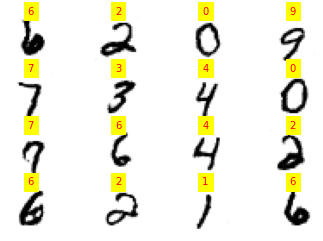



epoch -> [54/60], discriminator_loss_for_real_data = 337.56, discriminator_loss_for_fake_data = 282.85, generator_loss = 944.99



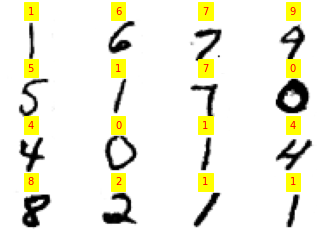



epoch -> [55/60], discriminator_loss_for_real_data = 335.69, discriminator_loss_for_fake_data = 278.44, generator_loss = 964.87



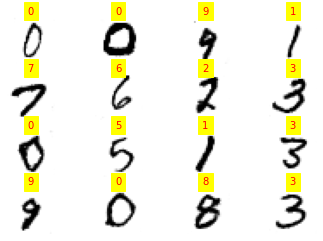



epoch -> [56/60], discriminator_loss_for_real_data = 332.45, discriminator_loss_for_fake_data = 270.38, generator_loss = 967.84



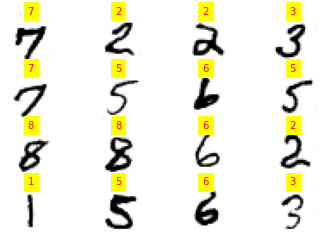



epoch -> [57/60], discriminator_loss_for_real_data = 331.70, discriminator_loss_for_fake_data = 273.55, generator_loss = 970.51



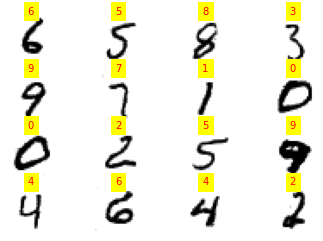



epoch -> [58/60], discriminator_loss_for_real_data = 329.00, discriminator_loss_for_fake_data = 267.16, generator_loss = 988.73



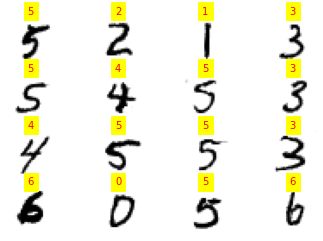



epoch -> [59/60], discriminator_loss_for_real_data = 326.91, discriminator_loss_for_fake_data = 267.88, generator_loss = 982.63



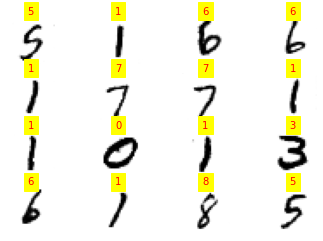



epoch -> [60/60], discriminator_loss_for_real_data = 320.97, discriminator_loss_for_fake_data = 262.49, generator_loss = 1000.75



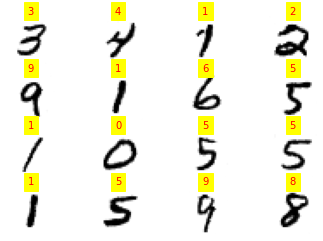

In [36]:
with tf.device(device_name):

  latent_dim = 100
  n_epochs = 60
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_r, d_loss_f, g_loss = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs)

## Plot Loss Values

In [37]:
loaded = np.load('/content/drive/MyDrive/CGAN_mnist/MSELoss1/loss_record.npz')
print(loaded['a'].shape)
print(loaded['b'].shape)
print(loaded['c'].shape)

(60,)
(60,)
(60,)


In [38]:
import matplotlib.pyplot as plot

g_loss = np.array(loaded['c'])

In [39]:
d_loss = np.array([(i+j) for i,j in zip(loaded['a'], loaded['b'])])

In [40]:
# print(d_loss_r)
# print(d_loss_f)
# print(d_loss)
# print(g_loss)

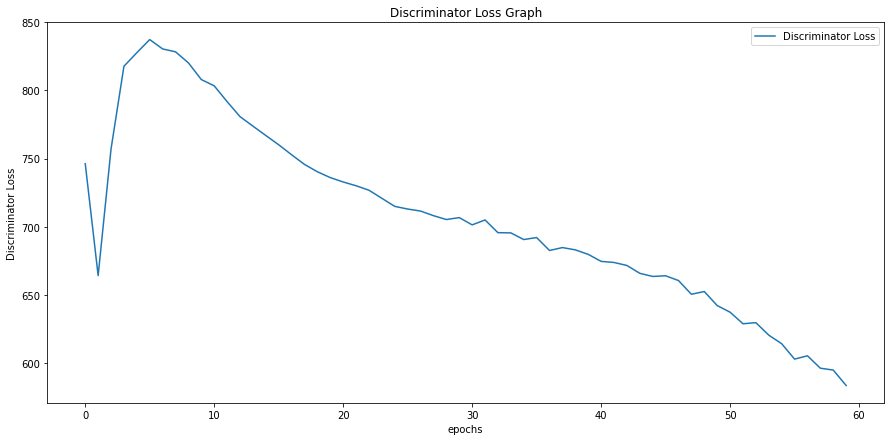

In [41]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.show()

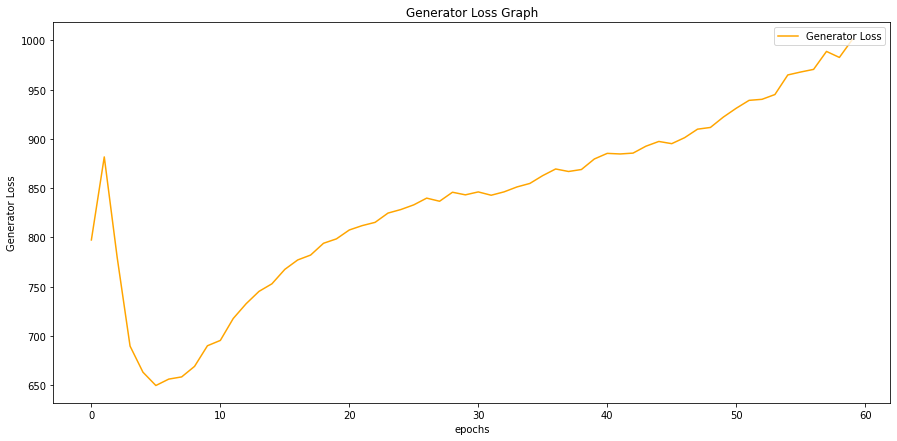

In [42]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.show()

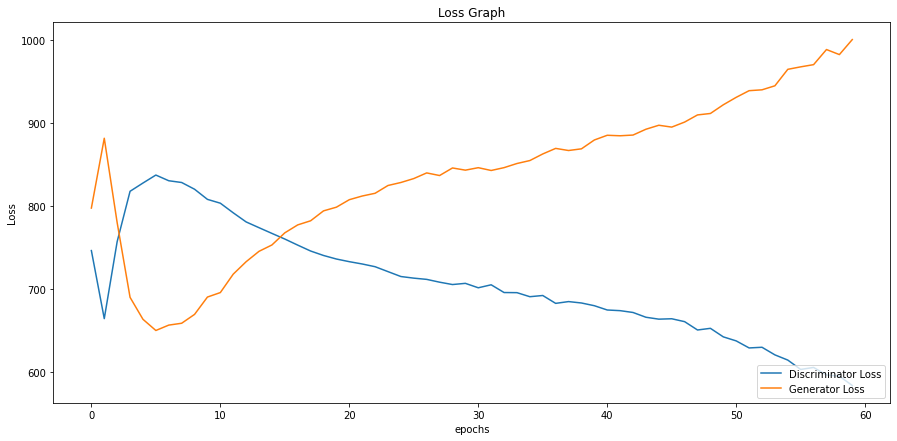

In [43]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.show()

# Prediction

latent points(latent points and labels):  (16, 100) (16,)

Generated images with labels:  (16, 28, 28, 1) 



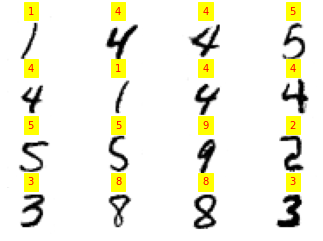

In [44]:
latent_dim = 100
n_samples = 16
z_input, labels = generate_latent_points(latent_dim, n_samples)
print("latent points(latent points and labels): ",z_input.shape, labels.shape)
data = [z_input,labels]
pred = g_model.predict(data)
pred = (pred +1 ) / 2.0
print("\nGenerated images with labels: ",pred.shape,'\n')
save_plot(pred,labels,n=4)

                                              -:END:-